In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont

In [4]:
def get_existing_chars(filename):
    ttfont = TTFont(filename)
    return list({chr(key) for table in ttfont['cmap'].tables for key in table.cmap.keys()})

def get_image(font, char, size=96):
    img = Image.new('L', (1000,1000), 255)

    draw = ImageDraw.Draw(img)
    draw.text((200,200), char, font=font)

    npimg = 255 - np.array(img)
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()

    npimg = 255 - npimg[hmin:hmax+1,wmin:wmax+1]

    whdiff = (wmax-wmin) - (hmax-hmin)
    wmargin = abs(whdiff) // 2 if whdiff < 0 else 0
    hmargin = abs(whdiff) // 2 if whdiff >= 0 else 0

    npimg = np.pad(npimg, ((hmargin, hmargin), (wmargin, wmargin)),
                       'constant', constant_values=255)
    img = Image.fromarray(npimg)
    
    return img

# utf-8
def get_all_korean():

    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()

    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns

In [5]:
ak = get_all_korean()

In [6]:
font_size = 70
filename = "/home/jupyter/ai_font/data/raw/ttfs/gulim.ttf"
font = ImageFont.truetype(filename,font_size)
existing_chars = get_existing_chars(filename)
iter_chars = list(set(existing_chars).intersection(set(ak)))
img_dict = {}
for l in iter_chars:
    img_dict[l] = get_image(font, l)

In [7]:
def resize_with_padding(img, ratio, new_size, padding_color=(255, 255, 255)):
    # Open the image
    # Get the new dimensions based on the ratio
    new_width = int(img.width * ratio)
    new_height = int(img.height * ratio)
    
    # Resize the image using the new dimensions
    resized_img = img.resize((new_width, new_height), Image.BILINEAR)
    
    # Create a new blank image with padding
    padded_img = Image.new("RGB", (new_size, new_size), padding_color)
    
    # Calculate the position to paste the resized image
    left = (padded_img.width - resized_img.width) // 2
    top = (padded_img.height - resized_img.height) // 2
    right = left + resized_img.width
    bottom = top + resized_img.height
    
    # Paste the resized image onto the blank image
    padded_img.paste(resized_img, (left, top, right, bottom))
    
    return padded_img

In [9]:
max_size = 0
for k,v in img_dict.items():
    size = v.size
    if max(size) > max_size:
        max_size = max(size)
ratio = 95/max_size

In [12]:
for k,v in tqdm(img_dict.items()):
    img = resize_with_padding(v, ratio, 96)
    with open(f"/home/jupyter/ai_font/data/processed/seen/gulim__{k}.png", "wb") as f:
        img.save(f, "PNG")

100%|██████████| 11172/11172 [00:10<00:00, 1092.25it/s]


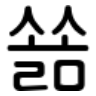

In [13]:
img

In [45]:
max(a.size)

64

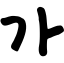

In [37]:
a